# AIHC Homework 5: Self Learning Tutorial
Evan Jones, evan_jones@utexas.edu ej8387



## Assignment description
### Details
For this assignment, you will create a self-learning tutorial using MIMIC data or other publicly available datasets. Being able to teach a concept requires you to have a clear understanding of the topic. Also figuring out the best way to explain something to different audiences helps deepen your understanding. For this project, you will learn how to do something and then create a tutorial that teaches it to someone else.
You must complete all parts of this assignment to receive full credit.

### Learning Outcomes
• Analyze data related to a healthcare topic using ML or DL methods
• Create a tutorial that teaches others your method using a presentation, speaker notes, and comments in Python code.
• Develop your ability to create and explain analyses.
• Evaluate the effectiveness of code tutorials for replicability.

### Part 1: Create a Tutorial
1. Select a topic related to healthcare using ML/DL methods. Our course lectures provide examples of the kind of projects we are looking for. Please do not do the exact same tutorials. You can extend the tutorials from the course, use different MIMIC tables, or choose different machine learning models.
2. Teach it to yourself by building a project. It should be in Python and contain detailed comments that others can use to rebuild your work. We suggest creating a private Google CoLab notebook or GitHub repository you can share.
3. Develop slides with step-by-step instructions you can teach to one of your peers. Use speaker notes to keep your slides clear and to the point. You are free to use Google Slides or PowerPoint. You have access to PowerPoint through your university Office 365 account. E
Note: If you use MIMIC-Ill for this tutorial, you must follow all of the requirements that you agreed to as a designated user of the dataset.

## Helper Code


In [ ]:
# Excerpt code from a given Jupyter notebook cell into an image suitable for
# use in a slide deck.
from IPython.display import display, Image

def code_to_image(
    filename:str,
    code_text:str|None=None,
    style:str="monokai",
    font_size=12,
    dpi:int=150,
    format="png",
    line_numbers=False,
):
    """
    Converts Jupyter notebook code cell content to an image.

    Parameters:
    -----------
    code_text: str|None, 
        text to be highlighted. If empty, use the currently executing cell
    style : str, default='monokai'
        Syntax highlighting style ('monokai', 'default', 'solarized-dark',
        'solarized-light', etc.)
    font_size : int, default=10
        Font size for the code text.
    dpi : int, default=150
        The resolution of the image in dots per inch.
    format : str, default='png'
        The image format ('png', 'jpg', 'svg', 'pdf', etc.).
    filename : str, default=None
        If provided, the image will be saved to this file.
    figsize : tuple, default=None
        Figure size in inches (width, height). If None, it's calculated based on content.
    line_numbers : bool, default=True
        Whether to include line numbers in the code image.

    Returns:
    --------
    IPython.display.Image or None
        The image object if filename is None, otherwise None.

    Example:
    --------
    # Capture the current cell
    code_to_image()

    # Capture a specific cell (e.g., the 3rd cell, index 2)
    code_to_image(cell_index=2)

    # Save to file with custom styling
    code_to_image(style='solarized-light', filename='my_code.png', dpi=300)
    """
    # Import required libraries for syntax highlighting
    from pygments import highlight
    from pygments.lexers import PythonLexer
    from pygments.formatters import ImageFormatter

    # In[-1] yields whichever cell was most recently invoked, the calling cell. 
    code_text = code_text or In[-1] # noqa

    # Create an image of the code with syntax highlighting
    formatter = ImageFormatter(
        style=style, font_size=font_size, line_numbers=line_numbers
    )
    image_bytes = highlight(code_text, PythonLexer(), formatter)

    # Save to file
    with open(filename, "wb") as f:
        f.write(image_bytes)
    print(f"Code image saved to {filename}")
    return filename
    # else:
    #     # Display the image
    #     img = Image(data=image_bytes)
    #     display(img)
    #     return img




## Tutorial Outline

### Problem Statement
My family was recently affected by unexpected side effects both of starting and 
stopping a new psychiatric drug. While all drugs come with some description of 
side effects, it's difficult to know how likely one is to encounter them, or how 
seriously one might be affected. 

Using a [dataset](https://www.kaggle.com/datasets/sepidehparhami/psychiatric-drug-webmd-reviews) of 62,000 reviews of psychiatric medications on WebMD, we use natural language processing 
to digest side effects reports for different drugs, and return searchable 
information summarizing common experiences.

It's worth noting that WebMD or other user-supplied-content repositories is **NOT** 
an unbiased or balanced source of information; most people will only leave reviews
for a medication they're *unhappy with*. However, if the worst that users have to
say about a drug is that it often makes them sleepy, that's much better than some 
subset of people believing the drug ruined their lives. (cf. [Mefloquine](https://en.wikipedia.org/wiki/Mefloquine))


### Dataset acquisition and processing


After downloading the [dataset](https://www.kaggle.com/datasets/sepidehparhami/psychiatric-drug-webmd-reviews) 
from Kaggle, we digest the two CSV files into a SQLite database for easy analysis 
and filtering.

In [4]:
# Read data from CSV with Pandas, store in a SQLite database
import pandas as pd
import sqlite_utils

df = pd.read_csv('psychiatric_drug_webmd_reviews.csv.zip')
print(f"Data set has {len(df)} rows, with columns: {list(df.columns)}")

# Load/create a database file
DB = sqlite_utils.Database("psych_med_reviews.sqlite")
table_name = "webmd_reviews"

# Add to DB if it's not already there
if table_name not in DB.table_names():
    DB[table_name].insert_all(df.to_dict(orient="records"))
print(f"Database table {table_name} has {DB[table_name].count} rows")

Data set has 61320 rows, with columns: ['Unnamed: 0', 'drug_name', 'date', 'age', 'gender', 'time_on_drug', 'reviewer_type', 'condition', 'rating_overall', 'rating_effectiveness', 'rating_ease_of_use', 'rating_satisfaction', 'text']
Database table webmd_reviews has 61320 rows


In [5]:
# Count words in reviews for each drug
column_details = DB[table_name].analyze_column('drug_name')

print(f"There are {column_details.num_distinct} unique medications in the database.")
# Generate a dictionary of drug names and their associated notes
drug_notes = {}
for row in DB[table_name].rows:
    drug_name = row['drug_name']
    note = row['text']
    if drug_name not in drug_notes:
        drug_notes[drug_name] = []
    drug_notes[drug_name].append(note)

print(f"Dictionary created with {len(drug_notes)} unique drugs")
# Count total words for each drug and show the max and min word count
word_counts = {}
for drug, notes in drug_notes.items():
    word_counts[drug] = 0
    if notes:
        word_counts[drug] = sum(len(note.split()) if note else 0 for note in notes)
# sort the entries in word_counts by length        
word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1]))


max_word_drug = max(word_counts, key=word_counts.get)
min_word_drug = min(word_counts, key=word_counts.get)

print(f"Drug with most words: {max_word_drug} ({word_counts[max_word_drug]} words)")
print(f"Drug with least words: {min_word_drug} ({word_counts[min_word_drug]} words)")


There are 201 unique medications in the database.
Dictionary created with 201 unique drugs
Drug with most words: Cymbalta Oral (294816 words)
Drug with least words: Vanatrip Oral (0 words)


### Set up the `llm` tool

In [6]:
# Make sure we've got an API key we can use, and install any needed plugins
# Get an Anthropic API Key, then store it with `llm`
# llm keys set anthropic 
# install the Anthropic plugin  
# llm install llm-anthropic
import llm
# Cost, as of 2025-03-14: $0.8/million tokens input, $4/mil output
model = llm.get_model("anthropic/claude-3-5-haiku-latest")
model


<Anthropic Messages: anthropic/claude-3-5-haiku-latest>

In [7]:

# find the first drug with 10_000 words of review and submit it to an llm for summary
trial_drug = next(drug for drug, count in word_counts.items() if count > 10_000)


review_prompt = f"""I'm appending a number of anonymized patient reviews for the 
medication {trial_drug} below. Please read the review and give me a short summary of 
patients' feelings about the drug. You might list people's favorite good points,
and least-liked elements about the experience. Pay attention to people who have 
very strong positive or negative experiences, and include excerpts from those 
reviews occasionally if they're very unusual. As an example, please don't include
any excerpts about common mild symptoms, but if one user reports life-changing 
headaches or amnesia, that's probably worth highlighting. Try to limit your summary
to about two hundred words. 

Please don't introduct the summary, just begin right away

Reviews follow, and each is bracketed by <review> to start and </review> to end.


"""


prompt_with_reviews = review_prompt + "\n".join([f'<review>{note}</review>' for note in drug_notes[trial_drug]])

drug_summaries = {}

response = model.prompt(prompt_with_reviews)
drug_summaries[trial_drug] = response.text()

print(drug_summaries[trial_drug])


Here's a summary of patients' experiences with Rexulti:

Positive Experiences:
- Significant improvement in depression symptoms
- Reduced anxiety and negative thoughts
- Increased motivation and energy
- Better cognitive function and emotional stability
- Helpful for bipolar disorder and mood regulation

Negative Experiences:
- Substantial weight gain (many reports of 10-40 pounds)
- Increased appetite
- Drowsiness and fatigue
- Vivid or disturbing dreams
- Some experienced worsened anxiety or mood swings
- Potential severe side effects like:
  - Memory issues
  - Parkinson-like symptoms
  - Panic attacks
  - Intense mood changes

Most patients reported mixed experiences, with many finding the mental health benefits outweighed the side effects. The medication seemed particularly effective for treatment-resistant depression and bipolar disorder.

Notable Excerpts:
- "Rexulti has changed my life for the better"
- "This drug almost ruined me had I continued to use it"
- "A miracle drug fo

We want to be able to group all records for a given medication together. 
Then we'll feed them into an LLM as context, and get a summary back. 

Steps:
- download data
- partition data by medication
- create a prompt describing the user experience summaries we want
- Use the `llm` tool to fetch summaries for each medication
- Create a searchable website to present information and 

### Data analysis


### Results and Conclusions

Code image saved to cell_out_2.png


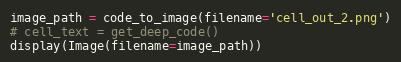

In [10]:
image_path = code_to_image(filename='assets/cell_out_2.png')
display(Image(filename=image_path))
